<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Create-dataset" data-toc-modified-id="Create-dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Create dataset</a></span><ul class="toc-item"><li><span><a href="#ROIs" data-toc-modified-id="ROIs-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>ROIs</a></span><ul class="toc-item"><li><span><a href="#ROI-in-signal-dimension" data-toc-modified-id="ROI-in-signal-dimension-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>ROI in signal dimension</a></span></li></ul></li><li><span><a href="#ROI-in-navigation-dimension" data-toc-modified-id="ROI-in-navigation-dimension-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>ROI in navigation dimension</a></span></li><li><span><a href="#Decomposition" data-toc-modified-id="Decomposition-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Decomposition</a></span></li></ul></li><li><span><a href="#Curve-fitting" data-toc-modified-id="Curve-fitting-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Curve fitting</a></span></li></ul></div>

# Create dataset

For this tutorial we are going to start by creating a dataset that does not fit in the RAM. In particular a spectrum image of size 

In [1]:
%matplotlib notebook

In [2]:
import hyperspy.api as hs

Let's import several libraries that we'll need to create the dataset

In [3]:
import skimage.data
import matplotlib.pyplot as plt
import numpy as np
import dask.array as da

In [4]:
def size_in_GB(shape, dtype):
    """Print the size of an array in GB
    
    Parameters
    ----------
    shape: tuple
        Shape of the array
    dtype: string or numpy dtype
        Valid numpy data type
        
    """
    size = np.prod(shape) * np.dtype(dtype).itemsize / 1e9
    print("%.1f GB" % size)

First lets load 4 512x512 images from skimage, convert them to grey and stack them

In [5]:
camera = hs.signals.Signal2D(skimage.data.load("camera.png", as_grey=True))
astronaut = hs.signals.Signal2D(skimage.data.load("astronaut.png", as_grey=True))
moon = hs.signals.Signal2D(skimage.data.load("moon.png", as_grey=True))
ihc = hs.signals.Signal2D(skimage.data.load("ihc.png", as_grey=True))
moon.change_dtype("float64")
moon.data /= moon.data.max()
camera.change_dtype("float64")
camera.data /= camera.data.max()
imgs = hs.stack([camera, astronaut, moon, ihc])

<IPython.core.display.Javascript object>


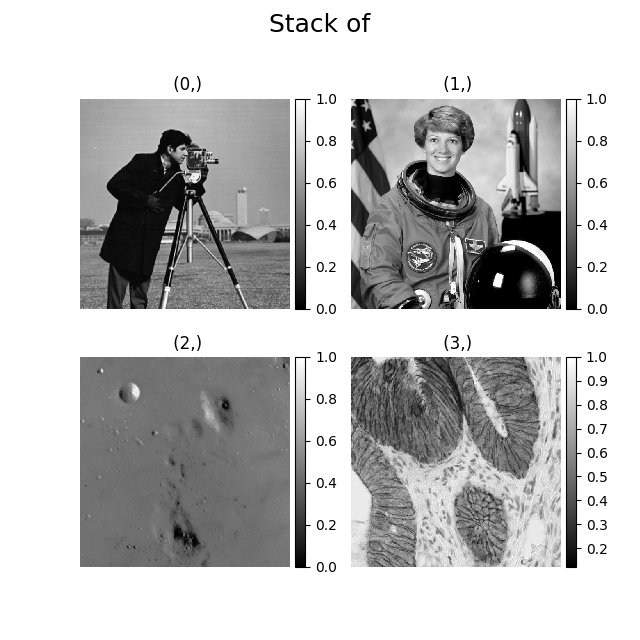

In [6]:
hs.plot.plot_images(imgs, per_row=2, axes_decor="off")

Now lets create 4 spectral signals composed of randomly distributed and weighted gaussians




<IPython.core.display.Javascript object>


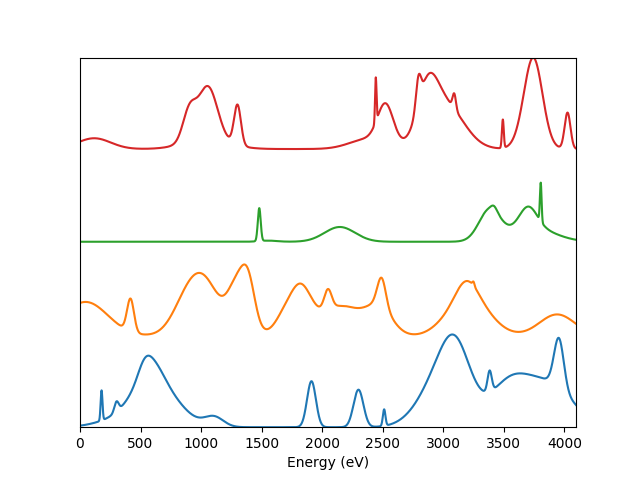

In [7]:
spectra = []
spectra_c = []
sd = hs.signals.Signal1D(np.zeros((4096,)))
sd.axes_manager[-1].units = "eV"
sd.axes_manager[-1].name = "Energy"

for i in range(4):
    m = sd.create_model()
    for position in np.random.randint(0, 4096, size=np.random.randint(8, 20)):
        m.append(
            hs.model.components1D.GaussianHF(
                centre=position,
                fwhm=np.random.randint(10, 500),
                height=np.random.randint(1, 100)))
    spectra.append(m.as_signal())
    spectra_c.append(
        hs.model.components1D.ScalableFixedPattern(
            signal1D=spectra[-1], interpolate=False))
    spectra_c[-1].shift.free = False
    spectra_c[-1].xscale.free = False
    spectra_c[-1].name = str(i)
spectra = hs.stack(spectra)
ax = hs.plot.plot_spectra(spectra, style="cascade")

In [67]:
# imgsr = imgs
# imgsr = imgs.rebin((4, 256, 256))
imgsr = imgs.rebin((4, 64, 64))

Create a *lazy* spectrum image

In [12]:
SIs = []
for spectrum, image in zip(spectra, imgsr):
    SIs.append(image.T.as_lazy() * spectrum.as_lazy())
s = SIs[0] + SIs[1] + SIs[2] + SIs[3] 

Add *lazy* poisson noise

In [13]:
s.data = da.random.poisson(s.data, chunks=s.data.chunks)